# Training Autonomous Vehicles using Augmented Random Search (ARS) in Carla

## Abstract
[Carla](https://carla.org/) is an open source driving simulator with a Python API used for autonomous driving research. Built on Unreal Engine 4, it employs high-end graphics to provide a suitable representation of the real world conducive for reinforcement learning with camera data. This research sought to test the ability of the [Augmented Random Searching (ARS) algorithm](https://arxiv.org/pdf/1803.07055.pdf) to train a self-driving car policy on the data gathered from a single front-facing camera per car. ARS is an exciting new algorithm for reinforcement learning (RL) proposed in 2018 by Mania, Guy, and Recht, which has been shown to achieve competitive results on benchmark MuJoCo continuous control locomotion tasks compared to more complex model-free methods, while offering at least 15x more computational efficiency. This significant reduction in computational resource requirements makes it an attractive algorithm for small-scale autonomous vehicle research, and so it was chosen for this study. Code for usable car environment for this task was derived from a [Sentdex tutorial on using Carla for Deep Q-Learning](https://medium.com/r/?url=https%3A%2F%2Fpythonprogramming.net%2Fintroduction-self-driving-autonomous-cars-carla-python%2F) and modified to fit the context of ARS learning. The modified environment was tested by splicing it into [ARS code provided by Colin Skow](https://medium.com/r/?url=https%3A%2F%2Fgithub.com%2Fcolinskow%2Fmove37) as a part of his course on RL. Once the environment was functional with ARS learning, the ability to train in parallel was achieved by modifying the [code provided by the authors of the ARS study](https://github.com/modestyachts/ARS) to make use of this car environment. This allowed testing of the efficacy of this efficient learning algorithm on training autonomous vehicles using camera data from Carla. To convert the raw RGB camera data into edge-case representations, it was first passed through the pretrained VGG19 convolutional neural network using imagenet weights, without the top layer. Even training the agent with 4 workers in parallel, the process of learning was slow. Testing a range of hyperparameters like learning rate and delta std requires multiple deployments of a multi-day training process, so the optimal balance for this task may have not been found by this study. RESULTS.

## Outline
[The Math Behind ARS](#ars_math)<br>
This section explains the mechanics of the ARS learning process.

[Testing Car Environment with ARS](#testing_environment)<br>
This section involves testing a modified version of Sentdex's Carla 'CarEnv' environment in the framework for ARS learning provided by Colin Skow.<br>

[Parallel Training using Ray](#parallel_training)<br>
This section makes use of a version of the ARS framework made available by the authors of the 2018 paper that has been modified to make use of the 'CarEnv' environment in a parallel fashion using a Ray cluster. This allows multiple workers to explore deltas simultaneously and pool the results of their rollouts.

<a id='ars_math'></a>
## The Math Behind ARS
To understand what happens under the hood during the ARS learning process, let's take a look at the equation found in the 2018 paper, which I have annotated for clarity.<br>
![ARS Formula](images/ars_formula_explained.png)<br>
In words, a user-defined number of deltas (random noise arrays with the same shape as the weights) are generated for each update step, and each delta is applied on 2 separate episodes: one in which it is added to the weights (positive direction) and one in which it is subtracted from the weights (negative direction). The rewards produced from the positive and negative directions are stored with their corresponding delta. Then the deltas are organized in order of maximum rewards produced in either the positive or negative direction, and then a user-defined number of the top performing deltas (up to the total number of deltas) are used in the update step (# deltas used). Each of the used deltas is multiplied by the difference between the rewards of the positive direction and the rewards of the negative direction corresponding to that delta, standardized by dividing these rewards by the collective standard deviation of all positive and negative rewards recorded from the deltas used during this step, which allows us to disregard the actual numerical scale of the reward system at hand. This effectively scales each delta by the magnitude of impact it had on performance, and reverses the sign when the negative direction has higher rewards than the positive direction. The result of each of these multiplication steps is then averaged by summing them together and dividing by the number of deltas used. The result is multiplied by the learning rate, then added to the weights, completing the update step.

<a id='testing_environment'></a>
## Testing Car Environment with ARS
Now that we have an understanding of the ARS process, let's look at how we can fit [Sentdex's car environment for Carla](https://pythonprogramming.net/reinforcement-learning-self-driving-autonomous-cars-carla-python/) into the [basic ARS framework offered by Colin Skow](https://github.com/colinskow/move37/tree/master/ars).

In [7]:
import datetime
import glob
import os
import sys
import random
import time
import numpy as np
import cv2
import math

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19

# Change the directory to where your carla egg file is located to load python module
try:
    sys.path.append(glob.glob('C:\ProgramData\Carla\PythonAPI\carla\dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass
import carla

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# Skow's Hyperparameter class
class HP():
    # Hyperparameters
    def __init__(self,
                 nb_steps=100,
                 episode_length=2000,
                 learning_rate=0.02,
                 num_deltas=16,
                 num_best_deltas=8,
                 noise=0.03,
                 seed=1,
                 env_name='BipedalWalker-v3',
                 record_every=50):

        self.nb_steps = nb_steps
        self.episode_length = episode_length
        self.learning_rate = learning_rate
        self.num_deltas = num_deltas
        self.num_best_deltas = num_best_deltas
        assert self.num_best_deltas <= self.num_deltas
        self.noise = noise
        self.seed = seed
        self.env_name = env_name
        self.record_every = record_every

In [10]:
# Skow's Policy class
class Policy():
    def __init__(self, input_size, output_size, hp, theta=None):
        self.input_size = input_size
        self.output_size = output_size
        if theta is not None:
            self.theta = theta
        else:
            #self.theta = np.random.random((output_size, input_size))
            self.theta = np.zeros((output_size, input_size))
        self.hp = hp

    def evaluate(self, input, delta = None, direction = None):
        if direction is None:
            return self.theta.dot(input)
        elif direction == "+":
            return (self.theta + self.hp.noise * delta).dot(input)
        elif direction == "-":
            return (self.theta - self.hp.noise * delta).dot(input)

    def sample_deltas(self):
        return [np.random.randn(*self.theta.shape) for _ in range(self.hp.num_deltas)]
#This code above here is super important 
#This is how the weights are updated according to which configuration of weights led to the biggest reward
    def update(self, rollouts, sigma_rewards):
        # sigma_rewards is the standard deviation of the rewards
        old_theta = self.theta.copy()
        step = np.zeros(self.theta.shape)
        for r_pos, r_neg, delta in rollouts:
            step += (r_pos - r_neg) * delta
        theta_update = self.hp.learning_rate / (self.hp.num_best_deltas * sigma_rewards) * step
        self.theta += theta_update
        if np.array_equal(old_theta, self.theta):
            print("Theta did not change.")

In [11]:
def mkdir(base, name):
    path = os.path.join(base, name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path

In [12]:
# Sentdex's CarEnv class, modified to work in the context of ARS learning
# This required giving it a continuous control scheme for use in a continuous
# action space. The camera input resolution has been changed to 224x224 since
# we will be running it through VGG19 to find edges, and this is the image
# resolution that VGG19 was originally trained on. I have set the number of
# seconds per episode to 15.
# The scoring system has been heavily modified to try and facilitate the learning
# process. Since cars will tend to learn to drive in circles in order to avoid
# collisions, it was necessary to punish driving in circles, and reward driving
# in straighter lines.
class CarEnv:

    def __init__(self, 
                 img_width=224, 
                 img_height=224, 
                 show_cam=False, 
                 control_type='continuous',
                 car_model='mustang',
                 seconds_per_episode=15
                ):
        self.img_width = img_width
        self.img_height = img_height
        self.client = carla.Client("localhost", 2000)
        self.client.set_timeout(5.0)
        self.world = self.client.get_world()
        self.blueprint_library = self.world.get_blueprint_library()
        self.car = self.blueprint_library.filter(car_model)[0]
        self.show_cam = show_cam
        self.control_type = control_type
        self.front_camera = None
        self.actor_list = []
        self.seconds_per_episode = seconds_per_episode
        
        if self.control_type == 'continuous':
            self.action_space = np.array(['throttle', 'steer', 'brake'])

    def reset(self):
        self.collision_hist = []
        
        if len(self.actor_list) > 0:
            for actor in self.actor_list:
                actor.destroy()
        self.actor_list = []
        
        try:
            self.transform = random.choice(self.world.get_map().get_spawn_points())
            self.vehicle = self.world.spawn_actor(self.car, self.transform)
            self.actor_list.append(self.vehicle)
        except:
            self.reset()

        # Attach RGB Camera
        self.rgb_cam = self.blueprint_library.find('sensor.camera.rgb')
        self.rgb_cam.set_attribute("image_size_x", f"{self.img_width}")
        self.rgb_cam.set_attribute("image_size_y", f"{self.img_height}")
        self.rgb_cam.set_attribute("fov", f"110")

        transform = carla.Transform(carla.Location(x=2.5, z=0.7))
        self.sensor = self.world.spawn_actor(self.rgb_cam, transform, attach_to=self.vehicle)
        self.actor_list.append(self.sensor)
        self.sensor.listen(lambda data: self.process_img(data))

        self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, brake=0.0))
        time.sleep(4)

        colsensor = self.blueprint_library.find("sensor.other.collision")
        self.colsensor = self.world.spawn_actor(colsensor, transform, attach_to=self.vehicle)
        self.actor_list.append(self.colsensor)
        self.colsensor.listen(lambda event: self.collision_data(event))

        while self.front_camera is None:
            time.sleep(0.01)

        self.episode_start = time.time()
        self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, brake=0.0))

        return self.front_camera

    def collision_data(self, event):
        self.collision_hist.append(event)

    def process_img(self, image):
        i = np.array(image.raw_data)
        i2 = i.reshape((self.img_height, self.img_width, 4))
        i3 = i2[:, :, :3]
        if self.show_cam:
            cv2.imshow("", i3)
            cv2.waitKey(1)
        self.front_camera = i3

    def step(self, action):
        if self.control_type == 'continuous':
            self.vehicle.apply_control(carla.VehicleControl(throttle=np.clip(action[0], 0.0, 1.0), 
                                                            steer=np.clip(action[1], -1.0, 1.0), 
                                                            brake=np.clip(action[2], 0.0, 1.0)))
            
        elif self.control_type == 'action':
            if action == 0:
                self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, 
                                                                steer=-1*self.STEER_AMT))
            elif action == 1:
                self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, steer= 0))
            elif action == 2:
                self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, 
                                                                steer=1*self.STEER_AMT))

        v = self.vehicle.get_velocity()
        kmh = int(3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2))

        if len(self.collision_hist) != 0:
            done = True
            reward = -200
        elif kmh < 60 & kmh > 0:
            done = False
            reward = -1
            # Reward lighter steering when moving
            if np.abs(action[1]) < 0.3:
                reward += 1
        elif kmh <=0:
            done = False
            reward = -10
        else:
            done = False
            reward = 2
            # Reward lighter steering when moving
            if np.abs(action[1]) < 0.3:
                reward += 1
            
        # Reduce score for heavy steering
        if np.abs(action[1]) > 0.5 and np.abs(action[1]) < 0.9:
            reward -= 1
        elif np.abs(action[1]) > 0.9:
            reward -= 2

        if self.episode_start + self.seconds_per_episode < time.time():
            done = True

        return self.front_camera, reward, done, None

In [13]:
# Generate a test car
test_car = CarEnv()

RuntimeError: time-out of 5000ms while waiting for the simulator, make sure the simulator is ready and connected to localhost:2000

In [ ]:
# Generate images for testing VGG19 predictions
#train_images = np.array([test_car.reset().reshape(224, 224, 3) for i in range(50)])

In [19]:
train_images.shape

(50, 224, 224, 3)

In [5]:
train_imgs2 = train_images.reshape(50, -1)
train_imgs2.shape

(50, 150528)

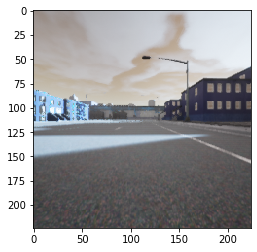

In [14]:
plt.imshow(train_imgs2[0].reshape(224, 224, 3)/255.);

In [ ]:
# Clean up actors in test_car
for actor in test_car.actor_list:
    actor.destroy()
del(test_car)

In [52]:
# Save generated images for later use
#train_imgs_dir = mkdir('', 'train_images')
#np.savetxt(train_imgs_dir + '/{}.csv'.format(datetime.date.today()), test_imgs2, delimiter=",")

In [16]:
train_imgs = np.genfromtxt('train_images/2020-12-10.csv', delimiter=',')

In [17]:
train_imgs.shape

(50, 150528)

In [20]:
# Skow's ARSAgent class, heavily modified to make use of the CarEnv
# initial_train option is experimental, uses train_imgs to train
# some initial weights for the ARS process to start with.
class ARSAgent():
    def __init__(self,
                 hp=None,
                 env=None,
                 base_model=True,
                 policy=None,
                 weights_dir='ars_weights',
                 initial_train=False
                ):

        self.hp = hp or HP()
        np.random.seed(self.hp.seed)
        self.env = env or CarEnv(control_type='continuous')
        self.output_size = self.env.action_space.shape[0]
        self.record_video = False
        self.history = {'step': [],
                        'score': [],
                        'theta': []}
        self.generate_theta = False
        self.historical_steps = 0
        
        if base_model is None:
            self.input_size = self.env.front_camera.shape
        else:
            base_model = VGG19(weights='imagenet', 
                               include_top=False, 
                               input_shape=(self.env.img_height, self.env.img_width,3))
            input_size = 1
            for dim in base_model.output_shape:
                if dim is not None:
                    input_size *= dim
            self.input_size = input_size
            
        if policy is None and initial_train == True:
            self.generate_theta = True
        self.base_model = base_model
        self.policy = policy or Policy(self.input_size, self.output_size, self.hp)
        self.weights_dir = mkdir('', weights_dir)

    # Explore the policy on one specific direction and over one episode
    def explore(self, direction=None, delta=None):
        state = self.env.reset()
        done = False
        sum_rewards = 0.0
        steps = 0
        while not done:
            state = self.env.front_camera.reshape(1, 224, 224, 3)/255.
            if self.base_model:
                state = self.base_model.predict(state).flatten()
            else:
                state = state.flatten()
            action = self.policy.evaluate(state, delta, direction)
            state, reward, done, _ = self.env.step(action)
            reward = max(min(reward, 1), -1)
            steps += 1
            sum_rewards += reward
        print('Worker saw {} steps'.format(steps))
        return sum_rewards

    def train(self):
        if self.generate_theta:
            print('Training initial weights...')
            pred_model = keras.models.Sequential()
            base_model = VGG19(weights='imagenet', 
                               include_top=False, 
                               input_shape=(224, 224,3))
            for layer in base_model.layers:
                layer.trainable = False
            pred_model.add(base_model)
            pred_model.add(keras.layers.Flatten())
            pred_model.add(Dense(3, input_dim=base_model.output_shape, activation='linear'))
            pred_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
            X = train_imgs.reshape(50, 224, 224, 3)/255.
            y = np.array([1., 0., 0.])
            y = np.tile(y, (50, 1))
            pred_model.fit(X, y, epochs=5, workers=2)
            self.policy.theta = pred_model.get_weights()[-2].T
        
        for step in range(self.hp.nb_steps):
            print('Performing step {}. ({}/{})'.format(self.historical_steps,
                                                       step + 1,
                                                       self.hp.nb_steps
                                                      ))
            self.historical_steps += 1
            # Only record video during evaluation, every n steps
            if step % self.hp.record_every == 0:
                self.env.show_cam = True
            # initialize the random noise deltas and the positive/negative rewards
            deltas = self.policy.sample_deltas()
            positive_rewards = [0] * self.hp.num_deltas
            negative_rewards = [0] * self.hp.num_deltas

            # play an episode each with positive deltas and negative deltas, collect rewards
            for k in range(self.hp.num_deltas):
                positive_rewards[k] = self.explore(direction="+", delta=deltas[k])
                negative_rewards[k] = self.explore(direction="-", delta=deltas[k])
                
            # Compute the standard deviation of all rewards
            sigma_rewards = np.array(positive_rewards + negative_rewards).std()

            # Sort the rollouts by the max(r_pos, r_neg) and select the deltas with best rewards
            scores = {k:max(r_pos, r_neg) for k,(r_pos,r_neg) in enumerate(zip(positive_rewards, negative_rewards))}
            order = sorted(scores.keys(), key = lambda x:scores[x], reverse = True)[:self.hp.num_best_deltas]
            rollouts = [(positive_rewards[k], negative_rewards[k], deltas[k]) for k in order]

            # Update the policy
            self.policy.update(rollouts, sigma_rewards)

            if step % self.hp.record_every == 0:
                # Play an episode with the new weights and print the score
                reward_evaluation = self.run_episode()
                print('Step:', step + 1, 'Reward:', reward_evaluation)
                self.history['step'].append(self.historical_steps)
                self.history['score'].append(reward_evaluation)
                self.history['theta'].append(self.policy.theta.copy())
                #self.save()
                
            self.env.show_cam = False
        
        self.save()

    def save(self):
        save_file = mkdir(self.weights_dir, str(datetime.date.today()))
        np.savetxt(save_file+'/recent_weights.csv'.format(self.historical_steps), 
                   self.policy.theta,
                   delimiter=','
                  )  
            
    def run_episode(self):
        return self.explore()
            
    def clean_up(self):
        for actor in self.env.actor_list:
            actor.destroy()

In [14]:
hp_test = HP(nb_steps=10, 
             noise=0.05, 
             learning_rate=0.02, 
             num_deltas=16, 
             num_best_deltas=8,
             record_every=1
            )

In [15]:
ars_agent = ARSAgent(hp=hp_test)

In [16]:
weights = np.genfromtxt('ars_weights/2020-12-11/recent_weights.csv', delimiter=',')

In [17]:
ars_agent.policy.theta = weights

In [47]:
#ars_agent.hp = hp_test

In [17]:
ars_agent.train()

Performing step 0. (1/50)
Step: 1 Reward: -2.0
Performing step 1. (2/50)
Step: 2 Reward: -6.0
Performing step 2. (3/50)
Step: 3 Reward: -7.0
Performing step 3. (4/50)
Step: 4 Reward: -1.0
Performing step 4. (5/50)
Step: 5 Reward: -1.0
Performing step 5. (6/50)
Step: 6 Reward: -3.0
Performing step 6. (7/50)
Step: 7 Reward: 0.0
Performing step 7. (8/50)
Step: 8 Reward: -2.0
Performing step 8. (9/50)
Step: 9 Reward: -1.0
Performing step 9. (10/50)
Step: 10 Reward: -6.0
Performing step 10. (11/50)
Step: 11 Reward: -8.0
Performing step 11. (12/50)
Step: 12 Reward: -1.0
Performing step 12. (13/50)
Step: 13 Reward: -4.0
Performing step 13. (14/50)
Step: 14 Reward: -5.0
Performing step 14. (15/50)
Step: 15 Reward: -1.0
Performing step 15. (16/50)
Step: 16 Reward: -1.0
Performing step 16. (17/50)
Step: 17 Reward: -6.0
Performing step 17. (18/50)
Step: 18 Reward: -1.0
Performing step 18. (19/50)
Step: 19 Reward: -1.0
Performing step 19. (20/50)
Step: 20 Reward: -6.0
Performing step 20. (21/50)
S

KeyboardInterrupt: 

In [16]:
ars_agent.train()

Performing step 0. (1/50)
Step: 1 Reward: -5.0
Performing step 1. (2/50)
Step: 2 Reward: -8.0
Performing step 2. (3/50)
Step: 3 Reward: -8.0
Performing step 3. (4/50)
Step: 4 Reward: -1.0
Performing step 4. (5/50)
Step: 5 Reward: -6.0
Performing step 5. (6/50)
Step: 6 Reward: -8.0
Performing step 6. (7/50)
Step: 7 Reward: -1.0
Performing step 7. (8/50)
Step: 8 Reward: -6.0
Performing step 8. (9/50)
Step: 9 Reward: -4.0
Performing step 9. (10/50)
Step: 10 Reward: -7.0
Performing step 10. (11/50)
Step: 11 Reward: -7.0
Performing step 11. (12/50)
Step: 12 Reward: -1.0
Performing step 12. (13/50)
Step: 13 Reward: 1.0
Performing step 13. (14/50)
Step: 14 Reward: -5.0
Performing step 14. (15/50)
Step: 15 Reward: -4.0
Performing step 15. (16/50)
Step: 16 Reward: -8.0
Performing step 16. (17/50)
Step: 17 Reward: -1.0
Performing step 17. (18/50)
Step: 18 Reward: -9.0
Performing step 18. (19/50)
Step: 19 Reward: -5.0
Performing step 19. (20/50)
Step: 20 Reward: -4.0
Performing step 20. (21/50)
S

KeyboardInterrupt: 

In [22]:
ars_agent.clean_up()

In [19]:
print(ars_agent.history['step'])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]


In [20]:
# A quick sanity check to make sure that our theta was changing each time
for i, theta in enumerate(ars_agent.history['theta']):
    if i + 1 == len(ars_agent.history['theta']):
        break
    if np.array_equal(theta, ars_agent.history['theta'][i+1]):
        print('same')
    else:
        print('different')

different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different


In [21]:
save_file = mkdir(ars_agent.weights_dir, str(datetime.date.today()))
np.savetxt(save_file+'/{}_episodes.csv'.format(ars_agent.history['step'][-1]), 
           ars_agent.history['theta'][-1],
           delimiter=','
          ) 

In [17]:
ars_agent.clean_up()
del(ars_agent)

In [ ]:
# We can see that we have a functioning ARS Agent using our CarEnv environment, but training
# with a single car like this would take forever. We need to look into training cars in
# parallel. Fortunately, the authors of the 2018 paper have provided source code to run ARS
# training in parallel using Ray. As was necessary with the Skow code, this code needed to be
# heavily modified in order to work with the CarEnv. I have made liberal adjustments to their
# code for this study. My version of the code can be found in the ARS folder.

<a id='parallel_training'></a>
## Parallel Training using Ray
Now that we have seen that our environment will work with ARS, it is time to do some serious training. Running only one car at a time at 15 seconds per episode would take forever to train, so we want to be able to have multiple cars exploring deltas simultaneously and pooling their results together for the update step. To do this, I have altered the code made available by Mania, Guy, and Recht to reproduce their research on MuJoCo locomotion tasks in order to implement the CarEnv instead. Their ARS framework includes functionality on a Ray server. In order for this to work, the reader must have ray installed using pip install ray. For Windows, use a non-administrator Powershell terminal using the same environment as this notebook to call 'ray start --head' as well as any parameters that are appropriate for your machine. The CarEnvs take up a lot of RAM, so it may be necessary to set your --object-store-memory and --memory parameters to as high of values as you can. You can call up the list of parameters with 'ray start --help'. Additionally, the terminal that this Jupyter notebook is running on must be a non-administrator terminal for this to work properly.

All of the code being run to perform this parallel training using ray can be found in the '[ARS](ARS/)' folder of this repository. Some noteable changes that I have made to the code include:
 - I have compartmentalized the observation filter functionality which takes rolling statistics of the inputs in order to normalize them, and wrapped it in a boolean parameter 'state_filter' which defaults to false, since the VGG19 outputs are all on a standard scale between 0-10. Experimenting both ways would be appropriate.
 - I have added learning rate decay, and delta standard deviation (called noise in Skow's code) decay, which can be adjusted by calling --lr_decay and --std_decay parameters. This allows for more exploration early on, and favoring smaller steps over time after some initial progress has been made.
 - I have added functionality which supports initializing the ARS process with a saved policy file, so that training can be resumed at a later time. The user can pass the saved policy file in .csv (weights only) or .npz (weights only or weights plus stats) format into the --policy_file parameter.
 - I have added a parameter called --show_cam which takes in an int telling the program how many cameras you would like to display from the group of workers. It defaults to 1, but for long training periods I recommend setting it to 0 in order to save CPU overhead.

If you have not already, make sure that your Carla simulator is running, and that you have started your ray server. Then, run the cells below.

In [23]:
%cd ARS
%pwd

C:\Users\indez\Documents\Flatiron\mod6project\ARS


'C:\\Users\\indez\\Documents\\Flatiron\\mod6project\\ARS'

In [24]:
!python code/ars.py --n_iter 1000 --num_deltas 32 --deltas_used 16 --learning_rate 0.05 \ 
--lr_decay 0.001 --delta_std 0.10 --std_decay 0.001 --n_workers 4 --show_cam 0 \
--seconds_per_episode 15 --dir_path './data/old_logs/2020-12-15_train1000'

^C


## Appendix
This section contains dead code no longer used in this notebook, but stored down here for reference if needed. An attempt was made at using ipyparallel, but luckily the Ray solution worked better.

In [3]:
# Skow's class to normalize inputs with rolling statistics
# Not used with the CarEnv since the outputs of the VGG19
# were all on the same scale, but it might be worth comparing
# using it later on.
class Normalizer():
    # Normalizes the inputs
    def __init__(self, nb_inputs):
        self.n = np.zeros(nb_inputs)
        self.mean = np.zeros(nb_inputs)
        self.mean_diff = np.zeros(nb_inputs)
        self.var = np.zeros(nb_inputs)

    def observe(self, x):
        self.n += 1.0
        last_mean = self.mean.copy()
        self.mean += (x - self.mean) / self.n
        self.mean_diff += (x - last_mean) * (x - self.mean)
        self.var = (self.mean_diff / self.n).clip(min = 1e-2)

    def normalize(self, inputs):
        obs_mean = self.mean
        obs_std = np.sqrt(self.var)
        return (inputs - obs_mean) / obs_std

In [4]:
# Original unmodified Skow Trainer class for reference
class ARSTrainer():
    def __init__(self,
                 hp=None,
                 input_size=None,
                 output_size=None,
                 normalizer=None,
                 policy=None,
                 monitor_dir=None):

        self.hp = hp or HP()
        np.random.seed(self.hp.seed)
        self.env = gym.make(self.hp.env_name)
        if monitor_dir is not None:
            should_record = lambda i: self.record_video
            self.env = wrappers.Monitor(self.env, monitor_dir, video_callable=should_record, force=True)
        self.hp.episode_length = self.hp.episode_length
        self.input_size = input_size or self.env.observation_space.shape[0]
        self.output_size = output_size or self.env.action_space.shape[0]
        self.normalizer = normalizer or Normalizer(self.input_size)
        self.policy = policy or Policy(self.input_size, self.output_size, self.hp)
        self.record_video = False

    # Explore the policy on one specific direction and over one episode
    def explore(self, direction=None, delta=None):
        state = self.env.reset()
        done = False
        num_plays = 0.0
        sum_rewards = 0.0
        while not done and num_plays < self.hp.episode_length:
            self.normalizer.observe(state)
            state = self.normalizer.normalize(state)
            action = self.policy.evaluate(state, delta, direction)
            state, reward, done, _ = self.env.step(action)
            reward = max(min(reward, 1), -1)
            sum_rewards += reward
            num_plays += 1
        return sum_rewards

    def train(self):
        for step in range(self.hp.nb_steps):
            # initialize the random noise deltas and the positive/negative rewards
            deltas = self.policy.sample_deltas()
            positive_rewards = [0] * self.hp.num_deltas
            negative_rewards = [0] * self.hp.num_deltas

            # play an episode each with positive deltas and negative deltas, collect rewards
            for k in range(self.hp.num_deltas):
                positive_rewards[k] = self.explore(direction="+", delta=deltas[k])
                negative_rewards[k] = self.explore(direction="-", delta=deltas[k])
                
            # Compute the standard deviation of all rewards
            sigma_rewards = np.array(positive_rewards + negative_rewards).std()

            # Sort the rollouts by the max(r_pos, r_neg) and select the deltas with best rewards
            scores = {k:max(r_pos, r_neg) for k,(r_pos,r_neg) in enumerate(zip(positive_rewards, negative_rewards))}
            order = sorted(scores.keys(), key = lambda x:scores[x], reverse = True)[:self.hp.num_best_deltas]
            rollouts = [(positive_rewards[k], negative_rewards[k], deltas[k]) for k in order]

            # Update the policy
            self.policy.update(rollouts, sigma_rewards)

            # Only record video during evaluation, every n steps
            if step % self.hp.record_every == 0:
                self.record_video = True
            # Play an episode with the new weights and print the score
            reward_evaluation = self.explore()
            print('Step: ', step, 'Reward: ', reward_evaluation)
            self.record_video = False

In [23]:
# This is an attempt to get the trainer to work with ipyparallel
# It did not work because ipyparallel will not pickle context objects
import ipyparallel as ipp
c = ipp.Client()
c[:].use_cloudpickle()

class ARSAgent_Parallel():
    def __init__(self,
                 hp=None,
                 num_envs=4,
                 base_model=True,
                 policy=None,
                 weights_dir='ars_weights',
                 initial_train=False
                ):

        self.hp = hp or HP()
        np.random.seed(self.hp.seed)
        self.envs = [CarEnv(control_type='continuous') for i in range(num_envs)]
        self.env = self.envs[0]
        self.output_size = self.env.action_space.shape[0]
        self.record_video = False
        self.history = {'step': [],
                        'score': [],
                        'theta': []}
        self.generate_theta = False
        self.historical_steps = 0
        
        if base_model is None:
            self.input_size = self.env.front_camera.shape
        else:
            base_model = VGG19(weights='imagenet', 
                               include_top=False, 
                               input_shape=(self.env.img_height, self.env.img_width,3))
            input_size = 1
            for dim in base_model.output_shape:
                if dim is not None:
                    input_size *= dim
            self.input_size = input_size
            
        if policy is None and initial_train == True:
            self.generate_theta = True
        self.base_model = base_model
        self.policy = policy or Policy(self.input_size, self.output_size, self.hp)
        self.weights_dir = mkdir('', weights_dir)
        
    # Explore the policy on one specific direction and over one episode
    def explore(self, direction=None, delta=None):
        state = self.env.reset()
        done = False
        sum_rewards = 0.0
        while not done:
            state = self.env.front_camera.reshape(1, 224, 224, 3)/255.
            if self.base_model:
                state = self.base_model.predict(state).flatten()
            else:
                state = state.flatten()
            action = self.policy.evaluate(state, delta, direction)
            state, reward, done, _ = self.env.step(action)
            reward = max(min(reward, 1), -1)
            sum_rewards += reward
        return sum_rewards

    # Explore the policy on one specific direction and over one episode
    def explore_directions(self, env):
        delta = np.random.randn(*self.policy.theta.shape)
        sum_positive_rewards = 0.0
        sum_negative_rewards = 0.0
        
        # Get positive direction for delta
        state = env.reset()
        done = False
        while not done:
            state = self.env.front_camera.reshape(1, 224, 224, 3)/255.
            if self.base_model:
                state = self.base_model.predict(state).flatten()
            else:
                state = state.flatten()
            action = self.policy.evaluate(state, delta, '+')
            state, reward, done, _ = self.env.step(action)
            #reward = max(min(reward, 1), -1)
            sum_positive_rewards += reward
            
        # Get negative direction for delta
        state = env.reset()
        done = False
        while not done:
            state = self.env.front_camera.reshape(1, 224, 224, 3)/255.
            if self.base_model:
                state = self.base_model.predict(state).flatten()
            else:
                state = state.flatten()
            action = self.policy.evaluate(state, delta, '-')
            state, reward, done, _ = self.env.step(action)
            reward = max(min(reward, 1), -1)
            sum_negative_rewards += reward
            
        return delta, sum_positive_rewards, sum_negative_rewards

    def train(self):
        if self.generate_theta:
            print('Training initial weights...')
            pred_model = keras.models.Sequential()
            base_model = VGG19(weights='imagenet', 
                               include_top=False, 
                               input_shape=(224, 224,3))
            for layer in base_model.layers:
                layer.trainable = False
            pred_model.add(base_model)
            pred_model.add(keras.layers.Flatten())
            pred_model.add(Dense(3, input_dim=base_model.output_shape, activation='linear'))
            pred_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
            X = train_imgs.reshape(50, 224, 224, 3)/255.
            y = np.array([1., 0., 0.])
            y = np.tile(y, (50, 1))
            pred_model.fit(X, y, epochs=5, workers=2)
            self.policy.theta = pred_model.get_weights()[-2].T
        
        for step in range(self.hp.nb_steps):
            print('Performing step {}. ({}/{})'.format(self.historical_steps,
                                                       step + 1,
                                                       self.hp.nb_steps
                                                      ))
            self.historical_steps += 1
            # Only record video during evaluation, every n steps
            if step % self.hp.record_every == 0:
                for env in self.envs:
                    env.show_cam = True
            # initialize the random noise deltas and the positive/negative rewards
            deltas = [] #self.policy.sample_deltas()
            positive_rewards = [] #[0] * self.hp.num_deltas
            negative_rewards = [] #[0] * self.hp.num_deltas

            # play an episode each with positive deltas and negative deltas, collect rewards
            for i in range(self.hp.num_deltas // 4):
                responses = c[:].map_sync(self.explore_directions, self.envs)
                for res in positive_responses:
                    deltas.append(res[0])
                    positive_rewards.append(res[1])
                    negative_rewards.append(res[3])
                
            # Compute the standard deviation of all rewards
            sigma_rewards = np.array(positive_rewards + negative_rewards).std()

            # Sort the rollouts by the max(r_pos, r_neg) and select the deltas with best rewards
            scores = {k:max(r_pos, r_neg) for k,(r_pos,r_neg) in enumerate(zip(positive_rewards, negative_rewards))}
            order = sorted(scores.keys(), key = lambda x:scores[x], reverse = True)[:self.hp.num_best_deltas]
            rollouts = [(positive_rewards[k], negative_rewards[k], deltas[k]) for k in order]

            # Update the policy
            self.policy.update(rollouts, sigma_rewards)

            if step % self.hp.record_every == 0:
                # Play an episode with the new weights and print the score
                reward_evaluation = self.run_episode()
                print('Step:', step + 1, 'Reward:', reward_evaluation)
                self.history['step'].append(self.historical_steps)
                self.history['score'].append(reward_evaluation)
                self.history['theta'].append(self.policy.theta.copy())
                
            self.env.show_cam = False
        
        save_file = mkdir(self.weights_dir, str(datetime.date.today()))
        np.savetxt(save_file+'/{}_episodes.csv'.format(self.historical_steps), 
                   self.policy.theta,
                   delimiter=','
                  )            
            
    def run_episode(self):
        return self.explore()
            
    def clean_up(self):
        for actor in self.env.actor_list:
            actor.destroy()

<AsyncResult: use_cloudpickle>

In [36]:
hp_test = HP(nb_steps=50, 
             noise=0.05, 
             learning_rate=0.02, 
             num_deltas=32, 
             num_best_deltas=16,
             record_every=1
            )

In [37]:
len(ars_agent.history['theta'])

26

In [38]:
ars_agent_parallel = ARSAgent_Parallel(hp=hp_test)

In [39]:
weights = ars_agent.history['theta'][-1]

In [40]:
ars_agent_parallel.policy.theta = weights

In [41]:
ars_agent_parallel.train()

Performing step 0. (1/50)


TypeError: can't pickle Context objects

In [42]:
ars_agent_parallel.clean_up()

I'd like to try training in a variety of circumstances and with various combinations of inputs. The semantic segmentation cam may give great performance with camera-based training. There are also radar, lidar, and other sensors that can be added into the inputs. First, let's just set up a basic RGB cam and try to see what that can do. I am thinking that putting the VGG19 with imagenet weights in front of the ARS agent may help it find edges, so we need to compare both of these methods over a given number of episodes. Sentdex's scoring system is not badly designed, and it may be enlightening to know how my scores compare.